In [28]:
# Import necessary libraries
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from model.maxsr_tiny import MaxSRTiny
from model.maxsr_super_tiny import MaxSRSuperTiny
from utils.utils import load_config, load_image
from utils.plotting import tensor_to_RGB_image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
images = ['21.jpeg', '23.jpeg', '35.jpeg', '64.jpeg', '83.jpeg']

In [30]:
# Load the images
lr_image_path = '/home/linuxu/Documents/datasets/Tiny_LR/'  
hr_image_path = '/home/linuxu/Documents/datasets/Tiny_HR/'  

lr_images = [lr_image_path + image for image in images]
hr_images = [hr_image_path + image for image in images]

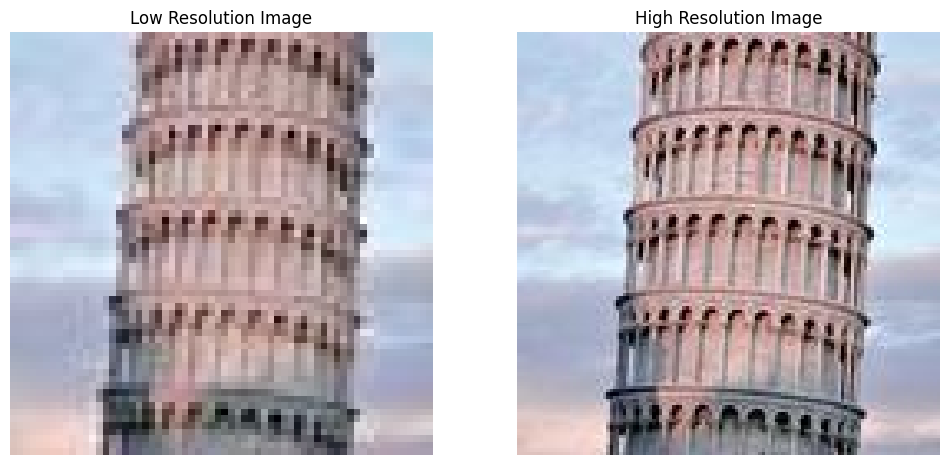

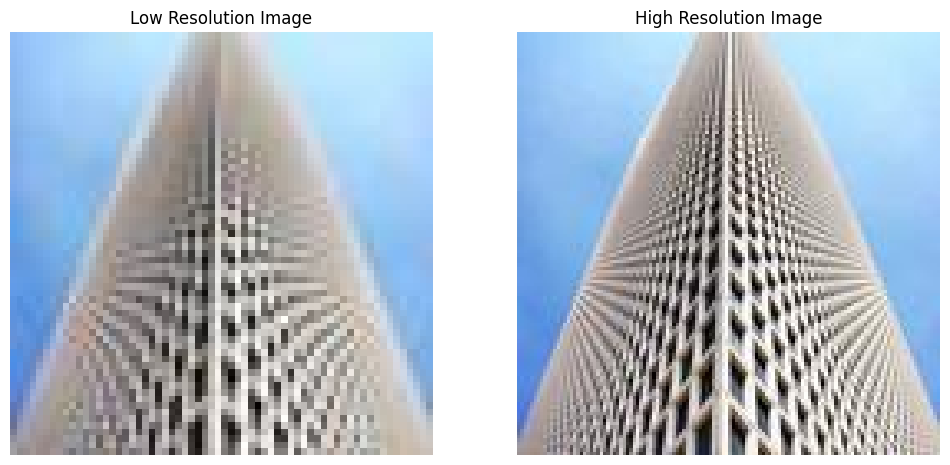

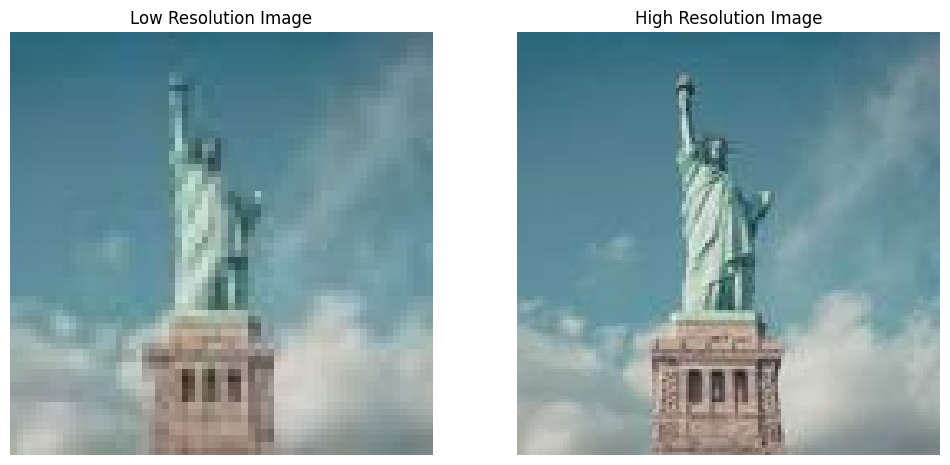

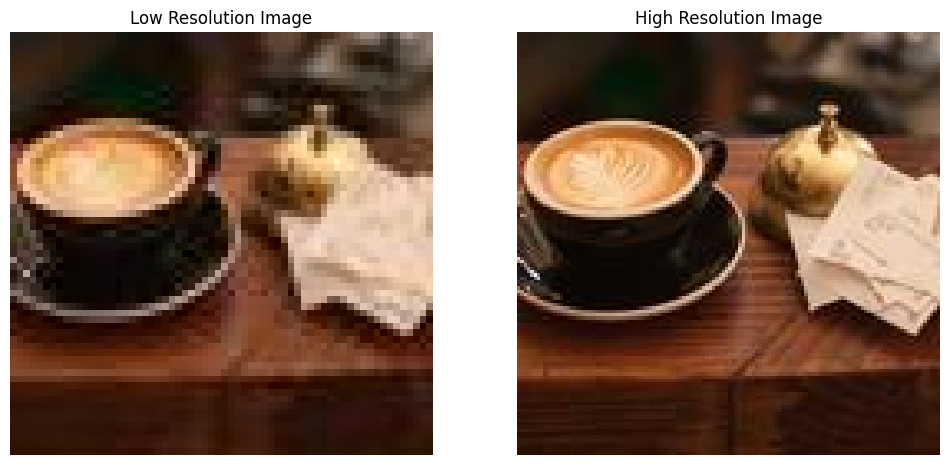

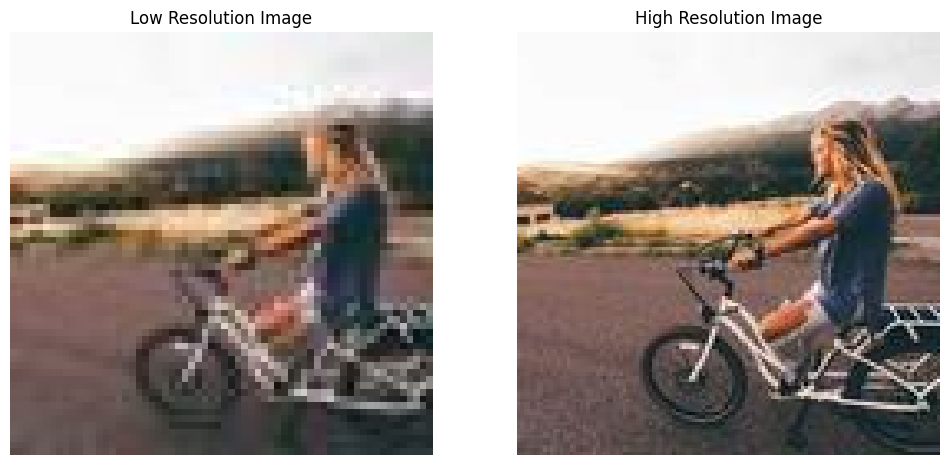

In [31]:
for lr, hr in zip(lr_images, hr_images):
    lr_image = Image.open(lr)
    hr_image = Image.open(hr)


    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Plot Low Resolution Image
    plt.subplot(1, 2, 1)
    plt.imshow(lr_image)
    plt.title('Low Resolution Image')
    plt.axis('off')

    # Plot High Resolution Image
    plt.subplot(1, 2, 2)
    plt.imshow(hr_image)
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.show()

# Inference - MaxSR-Super-Tiny

In [32]:
super_tiny_config = load_config(os.path.join(os.getcwd(), "config", "maxsr_super_tiny.yaml"))
super_tiny_config = super_tiny_config["model_config"]

# Load the pre-trained weights onto the correct device
super_tiny_model = MaxSRSuperTiny(super_tiny_config)

# Load the pre-trained weights
model_path = "/home/linuxu/Documents/models/MaxSR-super-tiny/20240820_160331/checkpoints/model-epoch-452.pth"
super_tiny_model.load_state_dict(torch.load(model_path, map_location=device))
super_tiny_model = super_tiny_model.to(device)

In [33]:
super_tiny_model.eval()

MaxSRSuperTiny(
  (sfe): ShallowFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (patch_embeddings): Linear(in_features=4096, out_features=256, bias=True)
  (positional_embedding): PositionalEmbedding()
  (stages): ModuleList(
    (0): Sequential(
      (0): AdaptiveMaxViTBlock(
        (mbconv): MBConv(
          (expand_conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
          (depthwise_conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
          (se_reduce): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (se_expand): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
          (project_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
          (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(1024, eps=1e

In [34]:
super_tiny_results = []
with torch.no_grad():
    for lr in lr_images:
        image = load_image(lr).to(device)
        output = super_tiny_model(image)
        st_image = tensor_to_RGB_image(output)
        super_tiny_results.append(Image.fromarray(st_image))

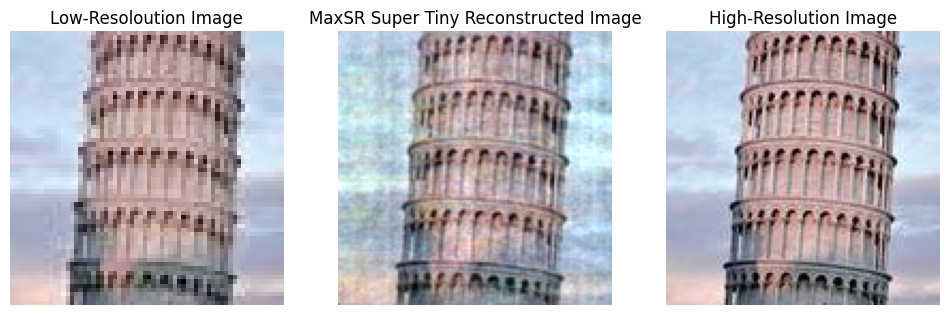

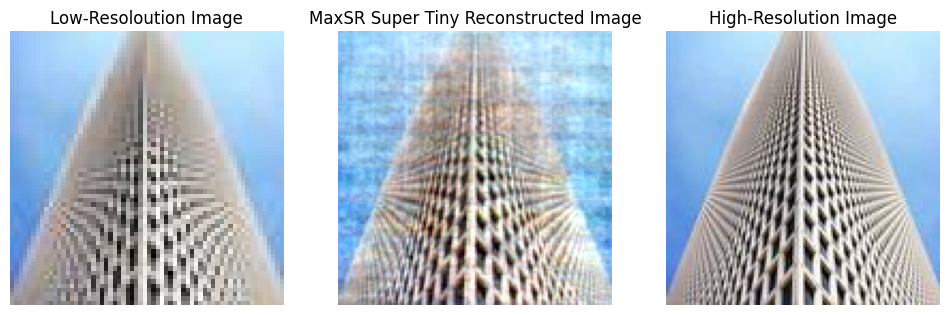

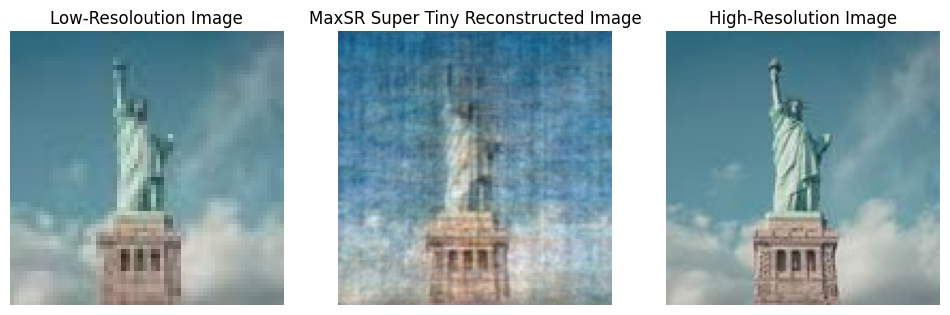

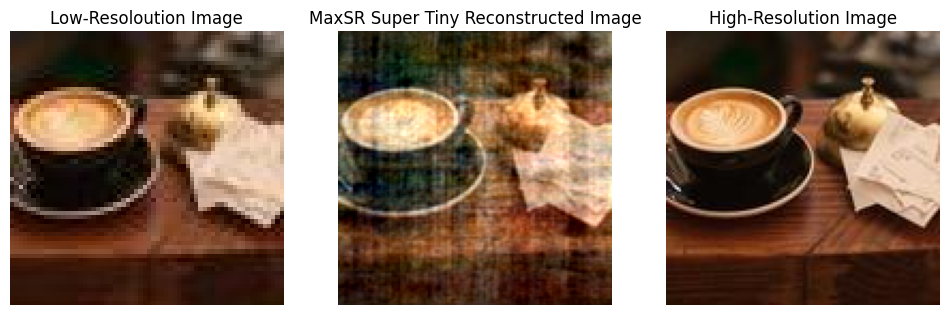

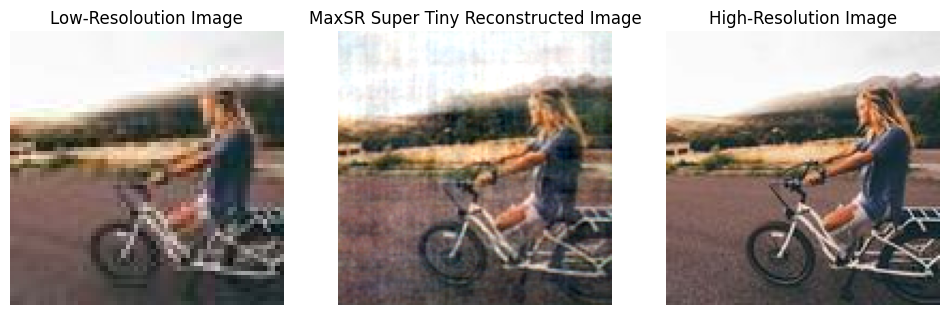

In [35]:
for lr, reconstructed_super_tiny_image, hr in zip(lr_images, super_tiny_results, hr_images):
    
    hr_image = Image.open(hr)
    lr_image = Image.open(lr)
    
    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Plot Reconstructed Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low-Resoloution Image')
    plt.axis('off')

    # Plot Reconstructed Image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_super_tiny_image)
    plt.title('MaxSR Super Tiny Reconstructed Image')
    plt.axis('off')

    # Plot High-Resolution Image
    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title('High-Resolution Image')
    plt.axis('off')


    plt.show()


# Inference - MaxSR-Tiny

In [36]:
tiny_config = load_config(os.path.join(os.getcwd(), "config", "maxsr_tiny.yaml"))
tiny_config = tiny_config["model_config"]

# Load the pre-trained weights onto the correct device
tiny_model = MaxSRTiny(tiny_config)

# Load the pre-trained weights
tiny_model_path = "/home/linuxu/Documents/models/MaxSR-tiny/20240820_163825/checkpoints/model-epoch-353.pth"
tiny_model.load_state_dict(torch.load(tiny_model_path, map_location=device))
tiny_model = tiny_model.to(device)

In [37]:
tiny_model.eval()

MaxSRTiny(
  (sfe): ShallowFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (patch_embeddings): Linear(in_features=4096, out_features=256, bias=True)
  (positional_embedding): PositionalEmbedding()
  (stages): ModuleList(
    (0-3): 4 x Sequential(
      (0): AdaptiveMaxViTBlock(
        (mbconv): MBConv(
          (expand_conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
          (depthwise_conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
          (se_reduce): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (se_expand): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
          (project_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
          (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(1024, eps=1

In [38]:
tiny_results = []
with torch.no_grad():
    for lr in lr_images:
        image = load_image(lr).to(device)
        output = tiny_model(image)
        st_image = tensor_to_RGB_image(output)
        tiny_results.append(Image.fromarray(st_image))

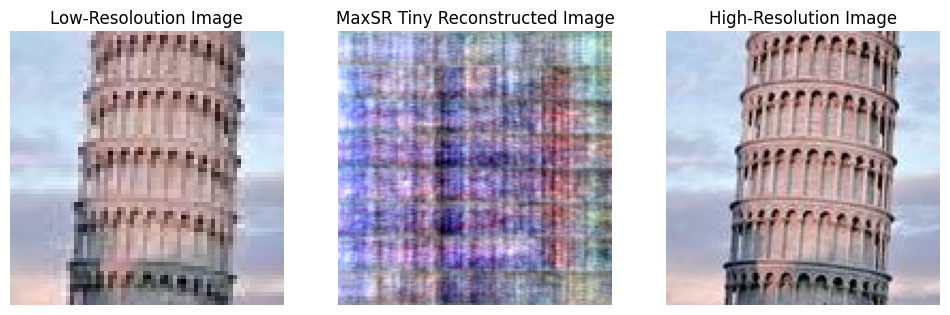

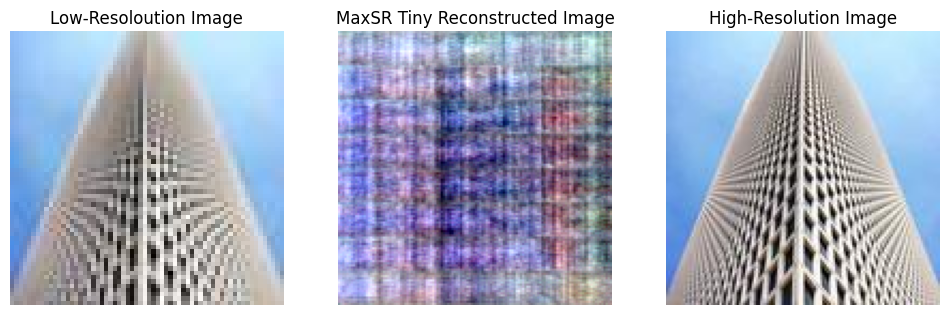

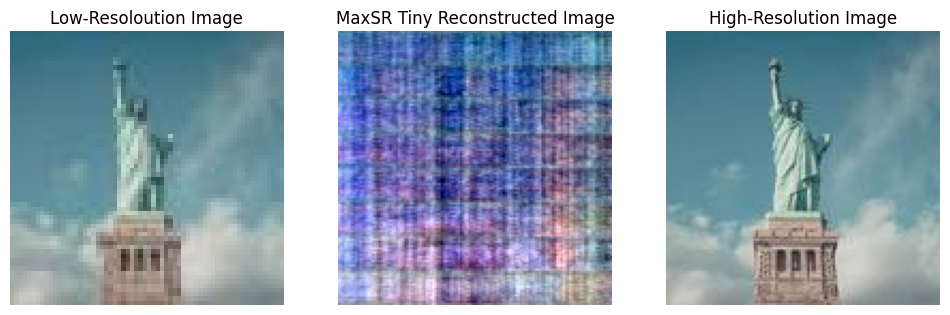

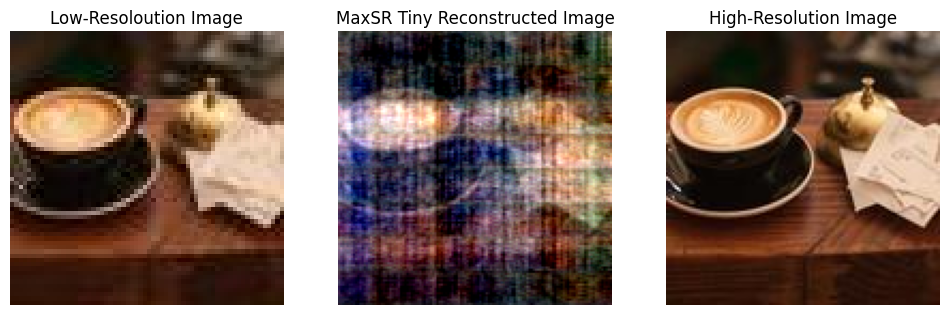

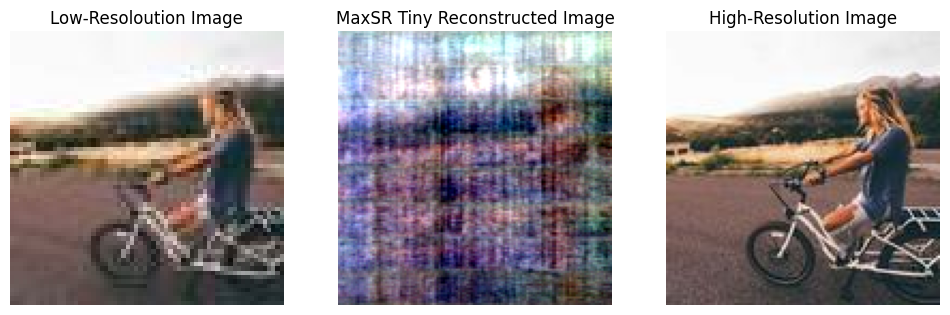

In [40]:
for lr, reconstructed_tiny_image, hr in zip(lr_images, tiny_results, hr_images):
    
    hr_image = Image.open(hr)
    lr_image = Image.open(lr)
    
    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Plot Reconstructed Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low-Resoloution Image')
    plt.axis('off')

    # Plot Reconstructed Image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_tiny_image)
    plt.title('MaxSR Tiny Reconstructed Image')
    plt.axis('off')

    # Plot High-Resolution Image
    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title('High-Resolution Image')
    plt.axis('off')


    plt.show()
